# Logistic Regression On PPU

PPU(Privacy-Preserving Processing Unit)是可证、可度量的密态设备，使用MPC协议进行隐私计算，目前支持SPDZ-2k, ABY3协议。PPU提供了基础的张量计算能力，以[XLA HLO](https://www.tensorflow.org/xla)作为IR，因此用户可以使用支持XLA的前端进行编程，如JAX, TensorFLow, PyTorch。关于PPU的更多细节，请参考：[PPU官方文档](https://ppu.antfin-inc.com/index.html)。

目前，PPU对JAX的支持比较完善，其他框架的支持没有得到充分测试，因此以下教程我们将使用JAX。

通过以下教程，你将初步了解如何在PPU进行机器学习建模。

这次教程我们选取了[Breast Cancer](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))，这是一个简单的二分类数据集，提供了三十个特征以判断是良性还是恶性乳腺癌。我们的场景是纵向分布，两方各自提供十五个特征最后得到一个逻辑回归模型。

第一步，我们先不考虑隐私计算的语义，直接利用JAX框架在明文下训练一个逻辑回归模型。

## 明文逻辑回归

### 产生数据

为了模拟纵向分布的场景，`load_dataset`将特征对半划分，一方持有一半特征和标签，另一方只持有特征。

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer


def load_dataset(return_label=False) -> (np.ndarray, np.ndarray):
    features, label = load_breast_cancer(return_X_y=True)

    if return_label:
        return features[:, 15:], label
    else:
        return features[:, :15], None

然后，我们对数据进行预处理，这有助于提升模型效果。这里我们使用sklearn对数据集进行均值方差归一化，使得各个特征符合标准正态分布。

In [2]:
from sklearn.preprocessing import StandardScaler

def transform(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

### 模型训练

#### 模型定义
首先，我们用JAX定义逻辑回归模型和损失函数。这是一份通用的代码，既可以CPU/GPU上运行，也可以在PPU运行，因此你可以很容易通过在CPU的运行结果检验PPU的正确性。

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))


# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)


# Training loss is the negative log-likelihood of the training examples.
def loss(W, b, inputs, targets):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.mean(jnp.log(label_probs))

其次，我们定义模型的优化器，为了简单起见，这里使用了SGD优化器。需要注意的是，x1, x2分别代表alice和bob的特征，由于是垂直划分，因此我们需要将它们按样本维度进行拼接。

In [4]:
from jax import value_and_grad

def train_step(W, b, x1, x2, y, learning_rate=1e-2) -> (np.ndarray, np.ndarray, np.ndarray):
    x = jnp.concatenate([x1, x2], axis=1)
    loss_value, Wb_grad  = value_and_grad(loss, (0, 1))(W, b, x, y)
    W -= learning_rate * Wb_grad[0]
    b -= learning_rate * Wb_grad[1]
    return loss_value, W, b

#### 训练循环

接下来，将上述的模型定义、损失函数、优化器组合成训练循环。在每个迭代中，我们将所有样本输入模型，更新参数，记录损失函数。

In [5]:
def fit(W, b, x1, x2, y, epochs=1, learning_rate=1e-2):    
    losses = jnp.array([])
    for _ in range(epochs):
        l, W, b = train_step(W, b, x1, x2, y, learning_rate=learning_rate)
        losses = jnp.append(losses, l)
    return losses, W, b

#### 指标可视化

我们可以观察训练集上的损失曲线变化，以进行参数调优。

In [6]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.plot(np.arange(len(losses)), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')

### 验证模型

让我们来观察一下训练集上的准确率和AUC。

In [7]:
from sklearn.metrics import roc_auc_score

def validate_model(W,b,x,y):
    y_pred = predict(W, b, jnp.concatenate([x1, x2], axis=1))
    auc = roc_auc_score(y, y_pred)
    acc = jnp.mean((y_pred > 0.5) == y)
    print(f'auc={auc}, acc={acc}')

## Build Together

auc=0.9838539189260611, acc=0.9349736571311951


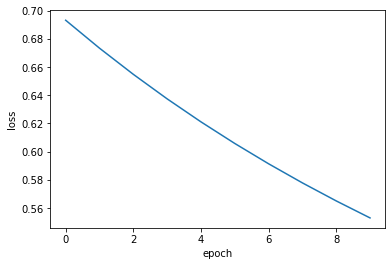

In [8]:
%matplotlib inline

# 1. 产生数据及预处理
x1, _ = load_dataset(return_label=False)
x2, y = load_dataset(return_label=True)

x1 = transform(x1)
x2 = transform(x2)

# 2.训练模型
W = jnp.zeros((30,))
b = 0.0
epochs = 10
learning_rate = 1e-2

losses, W, b = fit(W, b, x1, x2, y, epochs=10, learning_rate=1e-2)

# 3.指标可视化
plot_losses(losses)

# 4. 验证模型
validate_model(W,b, jnp.concatenate([x1, x2], axis=1), y)

In [9]:
import secretflow as sf

sf.init(['alice', 'bob'], num_cpus=8, log_to_driver=True)

我们在物理设备上虚拟出三个逻辑设备
- alice, bob：PYU设备，负责参与方本地的明文计算
- ppu：PPU设备，由alice和bob构成，负责两方的密文计算

In [10]:
alice, bob = sf.PYU('alice'), sf.PYU('bob')
ppu = sf.PPU(sf.utils.testing.cluster_def(['alice', 'bob']))

接下来，我们需要将load_dataset调度到逻辑设备alice、bob执行。在隐语中，用户可以通过`dev(fn)`将函数`fn`调度到指定的逻辑设备`dev`，后者可以是PYU、PPU、TEE等逻辑设备。函数执行返回对应的设备对象(DeviceObject)，设备对象可以理解为数据指针，指向位于远程的数据。

In [11]:
x1, _ = alice(load_dataset)(return_label=False)
x2, y = bob(load_dataset)(return_label=True)

x1, x2, y

(<secretflow.device.device.pyu.PYUObject at 0x7fa0a473aeb0>,
 <secretflow.device.device.pyu.PYUObject at 0x7fa2208f5ca0>)

然后，我们对数据进行预处理，这有助于提升模型效果。这里我们使用sklearn对数据集进行均值方差归一化，使得各个特征符合标准正态分布。

In [12]:
x1 = alice(transform)(x1)
x2 = bob(transform)(x2)

在开始训练之前，我们将逻辑回归模型的参数W, b初始化为0，连同x1, x2, y一起传输到PPU上。这是因为每个设备都有自己的数据存储方式，在其上运行的函数只接受对应类型的DeviceObject作为输入。隐语提供了以下两种设备传输方式：
- secretflow.to: 将一个python object或者device object传输到指定的设备
- DeviceObject.to: 将一个device object传输到指定的设备

In [13]:
device = ppu

W = jnp.zeros((30,))
b = 0.0

W_, b_, x1_, x2_, y_ = sf.to(device, W), sf.to(device, b), x1.to(device), x2.to(device), y.to(device)

(PPURuntime pid=63880) [2022-03-08 20:06:07.984] [info] [context.cc:58] connecting to mesh, id=root, self=0
(PPURuntime pid=63881) [2022-03-08 20:06:07.964] [info] [context.cc:58] connecting to mesh, id=root, self=1
(PPURuntime pid=63881) [2022-03-08 20:06:07.980] [info] [context.cc:83] try_connect to rank 0 not succeed, sleep_for 1000ms and retry.


(PPURuntime pid=63881) I0308 20:06:07.964183 63881 external/com_github_brpc_brpc/src/brpc/server.cpp:1046] Server[ppu::link::internal::ReceiverServiceImpl] is serving on port=21397.
(PPURuntime pid=63881) I0308 20:06:07.964281 63881 external/com_github_brpc_brpc/src/brpc/server.cpp:1049] Check out http://k69b13338.eu95sqa:21397 in web browser.
(PPURuntime pid=63880) I0308 20:06:07.984158 63880 external/com_github_brpc_brpc/src/brpc/server.cpp:1046] Server[ppu::link::internal::ReceiverServiceImpl] is serving on port=56300.
(PPURuntime pid=63880) I0308 20:06:07.984239 63880 external/com_github_brpc_brpc/src/brpc/server.cpp:1049] Check out http://k69b13338.eu95sqa:56300 in web browser.


以上准备工作就绪之后，我们就可以在PPU上开始训练了。训练完成之后，损失值和模型参数是存储在PPU上的PPUObject类型对象。

In [14]:
losses, W_, b_ = device(fit, static_argnames=['epochs'])(W_, b_, x1_, x2_, y_, epochs=10, learning_rate=1e-2)

losses, W_, b_

(PPURuntime pid=63881) I0308 20:06:08.065062 64226 external/com_github_brpc_brpc/src/brpc/socket.cpp:2202] Checking Socket{id=0 addr=127.0.0.1:56300} (0x7f3caef0bb40)
(PPURuntime pid=63881) I0308 20:06:08.065236 64226 external/com_github_brpc_brpc/src/brpc/socket.cpp:2262] Revived Socket{id=0 addr=127.0.0.1:56300} (0x7f3caef0bb40) (Connectable)


(<secretflow.device.device.ppu.PPUObject at 0x7fa22078e6d0>,
 <secretflow.device.device.ppu.PPUObject at 0x7fa22078e820>)

### 指标可视化

我们可以观察训练集上的损失曲线变化，以进行参数调优。但是`losses`此时为PPUObject，我们需要将它转换为python object。隐语提供了`sf.reveal`将任意类型的DeviceObject转换为python object。

> 请谨慎使用`sf.reveal`，否则有可能造成数据隐私泄漏。

(PPURuntime pid=63880) [2022-03-08 20:06:08.980] [info] [context.cc:111] connected to mesh, id=root, self=0
(PPURuntime pid=63881) [2022-03-08 20:06:08.980] [info] [context.cc:111] connected to mesh, id=root, self=1
(PPURuntime pid=63880) 20:06:14 TRACE: [Profiling] PPU execution completed, input processing took 0.004173861s, execution took 5.960133054s, output processing took 4.4542e-05s, total time 5.964351457s.
(PPURuntime pid=63881) 20:06:14 TRACE: [Profiling] PPU execution completed, input processing took 0.004294032s, execution took 5.961247655s, output processing took 3.8232e-05s, total time 5.965579919s.


Text(0, 0.5, 'loss')

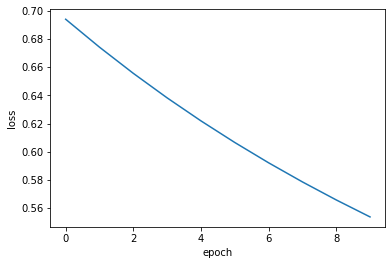

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

losses = sf.reveal(losses)

plt.plot(np.arange(len(losses)), losses)
plt.xlabel('epoch')
plt.ylabel('loss')

最后，让我们来观察一下训练集上的准确率和AUC。由于标签是在bob这一侧，因此我们在PPU上对训练样本进行打分，并将打分结果`y_pred`传输到bob，并在bob完成准确率和AUC的计算。

In [16]:
from sklearn.metrics import roc_auc_score

y_pred_ = device(lambda W, b, x1, x2: predict(W, b, jnp.concatenate([x1, x2], axis=1)))(W_, b_, x1_, x2_)
y_pred = y_pred_.to(bob)

auc = bob(roc_auc_score)(y, y_pred)
acc = bob(lambda y_true, y_pred: jnp.mean((y_pred > 0.5) == y_true))(y, y_pred)


print(f'auc={sf.reveal(auc)}, acc={sf.reveal(acc)}')

(PPURuntime pid=63880) 20:06:15 TRACE: [Profiling] PPU execution completed, input processing took 0.000440146s, execution took 0.157971411s, output processing took 2.506e-05s, total time 0.158436617s.
(PPURuntime pid=63881) 20:06:15 TRACE: [Profiling] PPU execution completed, input processing took 0.000469365s, execution took 0.157679088s, output processing took 2.8232e-05s, total time 0.158176685s.
auc=0.9838407060937583, acc=0.9349736571311951


(_run pid=63879) 2022-03-08 20:06:15,546,546 DEBUG [xla_bridge.py:_init_backend:262] Initializing backend 'interpreter'
(_run pid=63879) 2022-03-08 20:06:15,550,550 DEBUG [xla_bridge.py:_init_backend:274] Backend 'interpreter' initialized
(_run pid=63879) 2022-03-08 20:06:15,550,550 DEBUG [xla_bridge.py:_init_backend:262] Initializing backend 'cpu'
(_run pid=63879) 2022-03-08 20:06:15,557,557 DEBUG [xla_bridge.py:_init_backend:274] Backend 'cpu' initialized
(_run pid=63879) 2022-03-08 20:06:15,557,557 DEBUG [xla_bridge.py:_init_backend:262] Initializing backend 'tpu_driver'
(_run pid=63879) 2022-03-08 20:06:15,558,558 INFO [xla_bridge.py:backends:247] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
(_run pid=63879) 2022-03-08 20:06:15,558,558 DEBUG [xla_bridge.py:_init_backend:262] Initializing backend 'gpu'
(_run pid=63879) 2022-03-08 20:06:15,558,558 INFO [xla_bridge.py:backends:247] Unable to initialize backend 'gpu': NOT_FOUND:

In [17]:
import ray

ray.shutdown()

(_run pid=63879) 2022-03-08 20:06:15,613,613 DEBUG [dispatch.py:log_elapsed_time:184] Finished XLA compilation of _mean in 0.04593181610107422 sec


以上我们演示了如何利用PPU进行逻辑回归建模，你可以尝试将其应用于你的数据集。